In [ ]:
import pandas as pd
import numpy as np
import PIL
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image
import matplotlib.pyplot as plt
import os
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Conv2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,ReLU,Reshape
import tensorflow as tf

# PIC_DIR = './img_align_celeba/img_align_celeba'
# len(os.listdir(PIC_DIR))

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/img_align_celeba.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/img_align_celeba/197600.jpg  
  inflating: /content/data/img_align_celeba/197601.jpg  
  inflating: /content/data/img_align_celeba/197602.jpg  
  inflating: /content/data/img_align_celeba/197603.jpg  
  inflating: /content/data/img_align_celeba/197604.jpg  
  inflating: /content/data/img_align_celeba/197605.jpg  
  inflating: /content/data/img_align_celeba/197606.jpg  
  inflating: /content/data/img_align_celeba/197607.jpg  
  inflating: /content/data/img_align_celeba/197608.jpg  
  inflating: /content/data/img_align_celeba/197609.jpg  
  inflating: /content/data/img_align_celeba/197610.jpg  
  inflating: /content/data/img_align_celeba/197611.jpg  
  inflating: /content/data/img_align_celeba/197612.jpg  
  inflating: /content/data/img_align_celeba/197613.jpg  
  inflating: /content/data/img_align_celeba/197614.jpg  
  inflating: /content/data/img_align_celeba/197615.jpg  
  inflating: /content/data/img_align_

In [ ]:
path_celeb = []
train_path_celeb = "/content/data/img_align_celeba"
for path in os.listdir(train_path_celeb):
    if '.jpg' in path:
        path_celeb.append(os.path.join(train_path_celeb, path))

In [ ]:
len(path_celeb)

202599

In [ ]:
new_path=path_celeb[0:30000]

In [ ]:
crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]

for i in range(len(images)):
    images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    
images = np.array(images) 

In [ ]:
train_data = images

<Figure size 720x720 with 0 Axes>

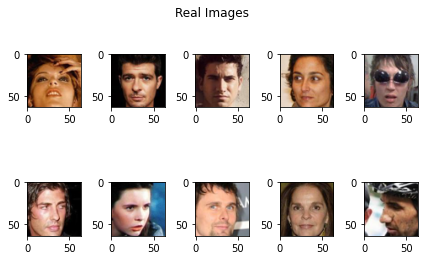

In [ ]:
plt.figure(figsize=(10,10))
fig,ax=plt.subplots(2,5)
fig.suptitle("Real Images")
idx=800

for i in range(2):
    for j in range(5):
            ax[i,j].imshow(train_data[idx].reshape(64,64,3))
            #ax[i,j].set_title("Real Image")
            
            idx+=1000
            
plt.tight_layout()
plt.show()

In [ ]:
train_data.shape

(30000, 64, 64, 3)

In [ ]:
X_train = train_data

In [ ]:
X_train.shape

(30000, 64, 64, 3)

In [ ]:
noise_shape = 100

In [ ]:
generator=Sequential()
generator.add(Dense(4*4*512,input_shape=[noise_shape]))
generator.add(Reshape([4,4,512]))
generator.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"))
generator.add(LeakyReLU(alpha=0.2))
generator.add(BatchNormalization())
generator.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding="same",
                                 activation='sigmoid'))

In [ ]:
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 256)        2097408   
 ranspose)                                                       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2d_transpose_5 (Conv2DT  (None, 16, 16, 128)     

In [ ]:
discriminator = Sequential()
discriminator.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=[64,64, 3]))
discriminator.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(128, (3,3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Conv2D(256, (3,3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.4))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

In [ ]:
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 128)        

In [ ]:
GAN =Sequential([generator,discriminator])

In [ ]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [ ]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [ ]:
GAN.layers

In [ ]:
GAN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 64, 64, 3)         3585219   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 392513    
                                                                 
Total params: 3,977,732
Trainable params: 3,584,323
Non-trainable params: 393,409
_________________________________________________________________


In [ ]:
epochs = 100  
batch_size = 128

In [ ]:
D_loss=[] 
G_loss=[] 

Currently on Epoch 1
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


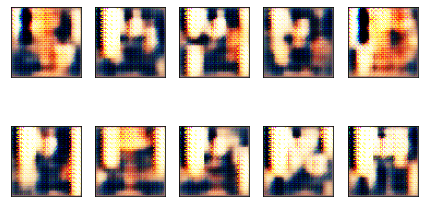

Epoch: 1,  Loss: D_real = 0.365, D_fake = 0.210,  G = 0.947
Currently on Epoch 2
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 2,  Loss: D_real = 0.569, D_fake = 0.034,  G = 2.091
Currently on Epoch 3
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 3,  Loss: D_real = 0.000, D_fake = 0.001,  G = 0.007
Currently on Epoch 4
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 4,  Loss: D_real = 0.037, D_fake = 0.011,  G = 5.162
Currently on Epoch 5
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 5,  Loss: D_real = 0.028, D_fake = 0.003,  G = 0.598
Currently on Epoch 6
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


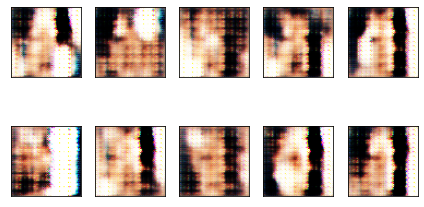

Epoch: 6,  Loss: D_real = 0.193, D_fake = 0.120,  G = 1.302
Currently on Epoch 7
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 7,  Loss: D_real = 0.126, D_fake = 0.029,  G = 1.984
Currently on Epoch 8
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 8,  Loss: D_real = 0.016, D_fake = 0.011,  G = 0.810
Currently on Epoch 9
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 9,  Loss: D_real = 0.077, D_fake = 0.028,  G = 2.027
Currently on Epoch 10
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 10,  Loss: D_real = 0.021, D_fake = 0.069,  G = 6.218
Currently on Epoch 11
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


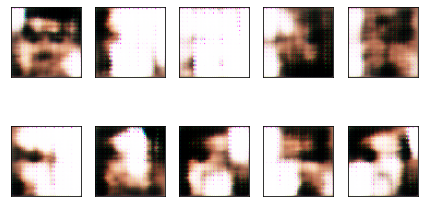

Epoch: 11,  Loss: D_real = 0.616, D_fake = 0.158,  G = 4.610
Currently on Epoch 12
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 12,  Loss: D_real = 0.009, D_fake = 0.161,  G = 7.216
Currently on Epoch 13
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 13,  Loss: D_real = 0.059, D_fake = 0.024,  G = 13.994
Currently on Epoch 14
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 14,  Loss: D_real = 0.082, D_fake = 0.033,  G = 4.884
Currently on Epoch 15
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 15,  Loss: D_real = 0.065, D_fake = 0.067,  G = 6.220
Currently on Epoch 16
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


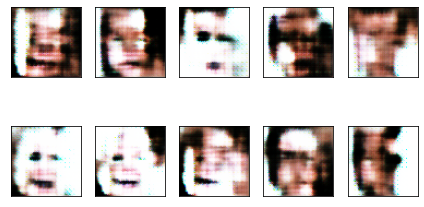

Epoch: 16,  Loss: D_real = 0.059, D_fake = 0.158,  G = 4.841
Currently on Epoch 17
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 17,  Loss: D_real = 0.139, D_fake = 0.141,  G = 5.861
Currently on Epoch 18
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 18,  Loss: D_real = 0.032, D_fake = 0.118,  G = 7.830
Currently on Epoch 19
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 19,  Loss: D_real = 0.241, D_fake = 0.068,  G = 3.978
Currently on Epoch 20
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 20,  Loss: D_real = 0.028, D_fake = 0.026,  G = 2.943
Currently on Epoch 21
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


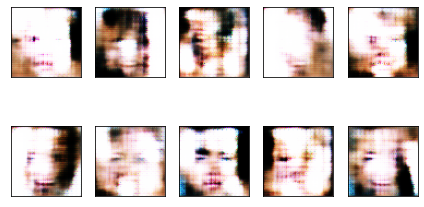

Epoch: 21,  Loss: D_real = 0.071, D_fake = 0.104,  G = 8.378
Currently on Epoch 22
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 22,  Loss: D_real = 0.130, D_fake = 0.030,  G = 9.681
Currently on Epoch 23
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 23,  Loss: D_real = 0.102, D_fake = 0.061,  G = 8.036
Currently on Epoch 24
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 24,  Loss: D_real = 0.025, D_fake = 0.061,  G = 4.376
Currently on Epoch 25
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 25,  Loss: D_real = 0.041, D_fake = 0.012,  G = 9.215
Currently on Epoch 26
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


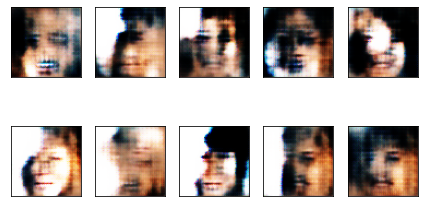

Epoch: 26,  Loss: D_real = 0.408, D_fake = 0.227,  G = 4.758
Currently on Epoch 27
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 27,  Loss: D_real = 0.080, D_fake = 0.039,  G = 7.117
Currently on Epoch 28
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 28,  Loss: D_real = 0.425, D_fake = 0.013,  G = 10.605
Currently on Epoch 29
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 29,  Loss: D_real = 0.200, D_fake = 0.189,  G = 3.832
Currently on Epoch 30
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 30,  Loss: D_real = 0.057, D_fake = 0.068,  G = 5.682
Currently on Epoch 31
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


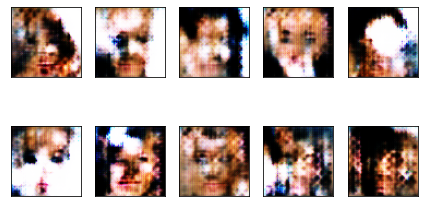

Epoch: 31,  Loss: D_real = 0.005, D_fake = 0.070,  G = 6.388
Currently on Epoch 32
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 32,  Loss: D_real = 0.056, D_fake = 0.043,  G = 8.916
Currently on Epoch 33
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 33,  Loss: D_real = 0.118, D_fake = 0.168,  G = 5.477
Currently on Epoch 34
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 34,  Loss: D_real = 0.083, D_fake = 0.006,  G = 6.801
Currently on Epoch 35
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 35,  Loss: D_real = 0.115, D_fake = 0.136,  G = 5.477
Currently on Epoch 36
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


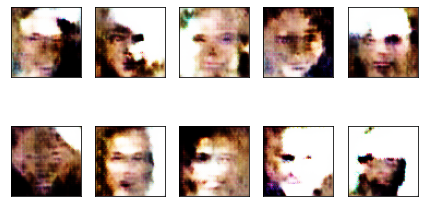

Epoch: 36,  Loss: D_real = 0.063, D_fake = 0.043,  G = 6.440
Currently on Epoch 37
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 37,  Loss: D_real = 0.098, D_fake = 0.017,  G = 5.836
Currently on Epoch 38
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 38,  Loss: D_real = 0.078, D_fake = 0.107,  G = 7.011
Currently on Epoch 39
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 39,  Loss: D_real = 0.161, D_fake = 0.001,  G = 12.818
Currently on Epoch 40
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 40,  Loss: D_real = 0.223, D_fake = 0.195,  G = 5.964
Currently on Epoch 41
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


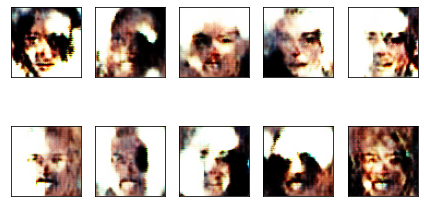

Epoch: 41,  Loss: D_real = 0.032, D_fake = 0.107,  G = 6.706
Currently on Epoch 42
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 42,  Loss: D_real = 0.151, D_fake = 0.047,  G = 6.606
Currently on Epoch 43
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 43,  Loss: D_real = 0.038, D_fake = 0.112,  G = 7.396
Currently on Epoch 44
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 44,  Loss: D_real = 0.050, D_fake = 0.032,  G = 6.047
Currently on Epoch 45
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 45,  Loss: D_real = 0.105, D_fake = 0.019,  G = 6.171
Currently on Epoch 46
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


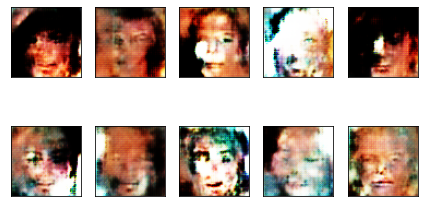

Epoch: 46,  Loss: D_real = 1.007, D_fake = 0.075,  G = 6.218
Currently on Epoch 47
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 47,  Loss: D_real = 0.107, D_fake = 0.028,  G = 7.486
Currently on Epoch 48
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 48,  Loss: D_real = 0.064, D_fake = 0.153,  G = 7.474
Currently on Epoch 49
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 49,  Loss: D_real = 0.052, D_fake = 0.029,  G = 6.500
Currently on Epoch 50
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 50,  Loss: D_real = 0.042, D_fake = 0.045,  G = 6.893
Currently on Epoch 51
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


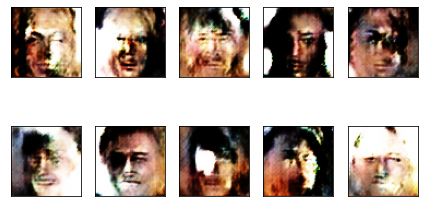

Epoch: 51,  Loss: D_real = 0.043, D_fake = 0.152,  G = 6.846
Currently on Epoch 52
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 52,  Loss: D_real = 0.046, D_fake = 0.119,  G = 6.302
Currently on Epoch 53
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 53,  Loss: D_real = 0.071, D_fake = 0.052,  G = 9.643
Currently on Epoch 54
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 54,  Loss: D_real = 0.032, D_fake = 0.080,  G = 6.720
Currently on Epoch 55
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 55,  Loss: D_real = 0.068, D_fake = 0.119,  G = 6.896
Currently on Epoch 56
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


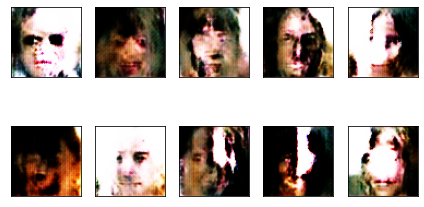

Epoch: 56,  Loss: D_real = 0.132, D_fake = 0.033,  G = 6.245
Currently on Epoch 57
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 57,  Loss: D_real = 0.063, D_fake = 0.277,  G = 5.166
Currently on Epoch 58
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 58,  Loss: D_real = 0.057, D_fake = 0.018,  G = 6.114
Currently on Epoch 59
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 59,  Loss: D_real = 0.028, D_fake = 0.132,  G = 6.022
Currently on Epoch 60
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 60,  Loss: D_real = 0.029, D_fake = 0.040,  G = 6.677
Currently on Epoch 61
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


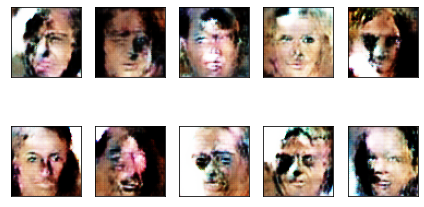

Epoch: 61,  Loss: D_real = 0.028, D_fake = 0.042,  G = 10.012
Currently on Epoch 62
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 62,  Loss: D_real = 0.333, D_fake = 0.091,  G = 5.969
Currently on Epoch 63
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 63,  Loss: D_real = 0.037, D_fake = 0.077,  G = 6.367
Currently on Epoch 64
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 64,  Loss: D_real = 0.028, D_fake = 0.105,  G = 5.555
Currently on Epoch 65
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 65,  Loss: D_real = 0.137, D_fake = 0.063,  G = 6.647
Currently on Epoch 66
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


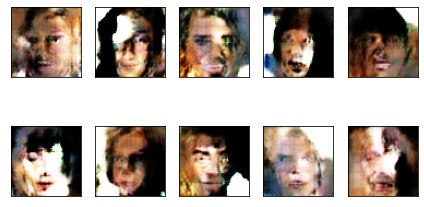

Epoch: 66,  Loss: D_real = 0.001, D_fake = 4.884,  G = 9.844
Currently on Epoch 67
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 67,  Loss: D_real = 0.245, D_fake = 0.133,  G = 6.263
Currently on Epoch 68
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 68,  Loss: D_real = 0.068, D_fake = 0.135,  G = 5.860
Currently on Epoch 69
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 69,  Loss: D_real = 0.193, D_fake = 0.025,  G = 5.936
Currently on Epoch 70
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 70,  Loss: D_real = 0.311, D_fake = 0.139,  G = 5.699
Currently on Epoch 71
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


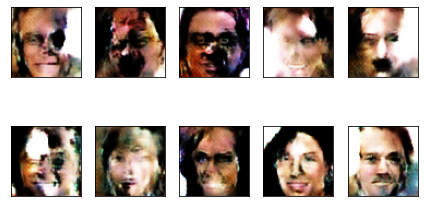

Epoch: 71,  Loss: D_real = 0.132, D_fake = 0.041,  G = 6.035
Currently on Epoch 72
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 72,  Loss: D_real = 0.070, D_fake = 0.084,  G = 6.485
Currently on Epoch 73
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 73,  Loss: D_real = 0.203, D_fake = 0.057,  G = 6.826
Currently on Epoch 74
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 74,  Loss: D_real = 0.208, D_fake = 0.016,  G = 6.456
Currently on Epoch 75
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 75,  Loss: D_real = 0.083, D_fake = 0.110,  G = 7.096
Currently on Epoch 76
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


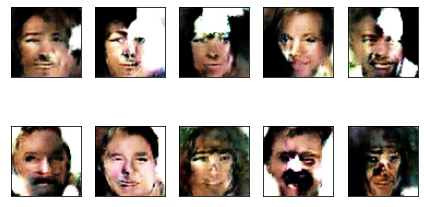

Epoch: 76,  Loss: D_real = 0.017, D_fake = 0.094,  G = 7.451
Currently on Epoch 77
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 77,  Loss: D_real = 0.264, D_fake = 0.242,  G = 5.936
Currently on Epoch 78
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 78,  Loss: D_real = 0.044, D_fake = 0.026,  G = 8.136
Currently on Epoch 79
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 79,  Loss: D_real = 0.238, D_fake = 0.143,  G = 6.356
Currently on Epoch 80
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 80,  Loss: D_real = 0.504, D_fake = 0.006,  G = 7.945
Currently on Epoch 81
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


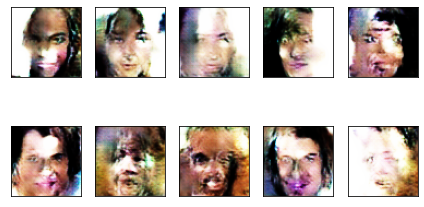

Epoch: 81,  Loss: D_real = 0.138, D_fake = 0.109,  G = 6.464
Currently on Epoch 82
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 82,  Loss: D_real = 0.089, D_fake = 0.091,  G = 8.273
Currently on Epoch 83
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 83,  Loss: D_real = 0.120, D_fake = 0.011,  G = 6.451
Currently on Epoch 84
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 84,  Loss: D_real = 0.064, D_fake = 0.038,  G = 7.052
Currently on Epoch 85
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 85,  Loss: D_real = 0.148, D_fake = 0.026,  G = 7.307
Currently on Epoch 86
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


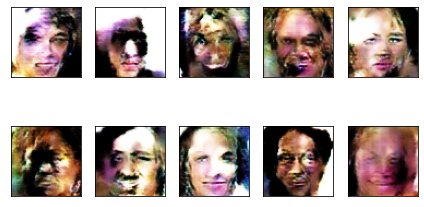

Epoch: 86,  Loss: D_real = 0.062, D_fake = 0.006,  G = 9.136
Currently on Epoch 87
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 87,  Loss: D_real = 0.070, D_fake = 0.064,  G = 7.423
Currently on Epoch 88
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 88,  Loss: D_real = 0.183, D_fake = 0.083,  G = 6.333
Currently on Epoch 89
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 89,  Loss: D_real = 0.053, D_fake = 0.208,  G = 6.754
Currently on Epoch 90
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 90,  Loss: D_real = 0.039, D_fake = 0.342,  G = 6.205
Currently on Epoch 91
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234


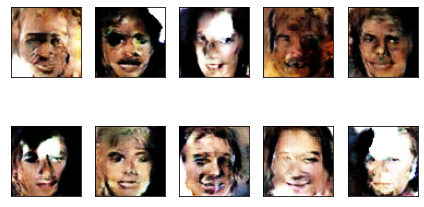

Epoch: 91,  Loss: D_real = 0.100, D_fake = 0.218,  G = 5.638
Currently on Epoch 92
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 92,  Loss: D_real = 0.024, D_fake = 0.048,  G = 8.230
Currently on Epoch 93
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234
	Currently on batch number 200 of 234
Epoch: 93,  Loss: D_real = 0.217, D_fake = 0.088,  G = 5.537
Currently on Epoch 94
	Currently on batch number 0 of 234
	Currently on batch number 100 of 234


KeyboardInterrupt: ignored

In [ ]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
            
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        
        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
        
        noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)

    if epoch % 10 == 0:
        generator.save('/content/gdrive/MyDrive/generator.h5')
        discriminator.save('/content/gdrive/MyDrive/discriminator.h5')
        GAN.save("/content/gdrive/MyDrive/gans.h5")    
         
    if epoch % 5 == 0:
        samples = 10
        x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])

        
        plt.tight_layout()
        plt.show()
    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

In [ ]:
generator = tf.keras.models.load_model("/content/gdrive/MyDrive/generator.h5")

(64, 64, 3)


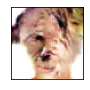

(64, 64, 3)


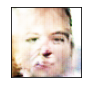

(64, 64, 3)


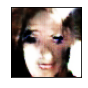

(64, 64, 3)


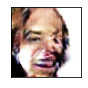

(64, 64, 3)


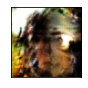

(64, 64, 3)


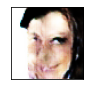

(64, 64, 3)


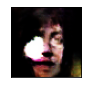

(64, 64, 3)


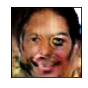

(64, 64, 3)


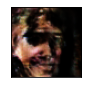

(64, 64, 3)


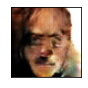

In [ ]:
# im=generator.predict(noise)
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(20,100)))

for k in range(10):
            plt.subplot(2, 5, k+1)
            print(x_fake[k].shape)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()

In [ ]:
discriminator.save("/content/gdrive/MyDrive/discriminator.h5")

In [ ]:
GAN.save("/content/gdrive/MyDrive/Gan.h5")

In [ ]:
samples = 10
x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples,100)))

for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(64,64,3))
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()